# Capital Allocation Line #

### Building Portfolios Maximizing Sharpe Ratio ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data
from portfolios_toolkit import portfolio_variance
from portfolios_toolkit import eff_coefficients
from portfolios_toolkit import eff_equation

In [3]:
tickers = get_tickers(mod="2.3")

tickers

['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM']

In [4]:
# Import data
df_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

Data Ready for AAPL
Data Ready for AMZN
Data Ready for JPM
Data Ready for JNJ
Data Ready for XOM


In [5]:
df_returns

,AAPL,AMZN,JPM,JNJ,XOM
2015-01-05 00:00:00,-0.028576,-0.020731,-0.031537,-0.007009,-0.027743
2015-01-06 00:00:00,0.000094,-0.023098,-0.026271,-0.004926,-0.005330
2015-01-07 00:00:00,0.013925,0.010544,0.001525,0.021836,0.010081
2015-01-08 00:00:00,0.037702,0.006813,0.022100,0.007832,0.016508
2015-01-09 00:00:00,0.001072,-0.011818,-0.017540,-0.013723,-0.001410
...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.016310,0.003985,0.000940
2024-12-26 00:00:00,0.003171,-0.008770,0.003420,-0.001853,0.000845
2024-12-27 00:00:00,-0.013331,-0.014641,-0.008135,-0.003647,-0.000094
2024-12-30 00:00:00,-0.013352,-0.011010,-0.007700,-0.011859,-0.006785


In [6]:
# Create the expected returns and standard deviations
expected_returns = df_returns.mean()
volatility = df_returns.dropna().std()
cov_matrix = df_returns.dropna().cov()

In [7]:
# Get the coefficients of the Efficient Frontier
coefficients = eff_coefficients(expected_returns, cov_matrix)

coefficients

(0.000167756977641719, 0.3215723784103435, 418.58785259659805)

In [29]:
# Create a rango of values for mu_P
mu_P_values = np.linspace(0.0, 0.004, 400)

# Evaluate the equation for mu_P values
sigma_P_values = eff_equation(coefficients, mu_P_values).reshape(-1, 1)

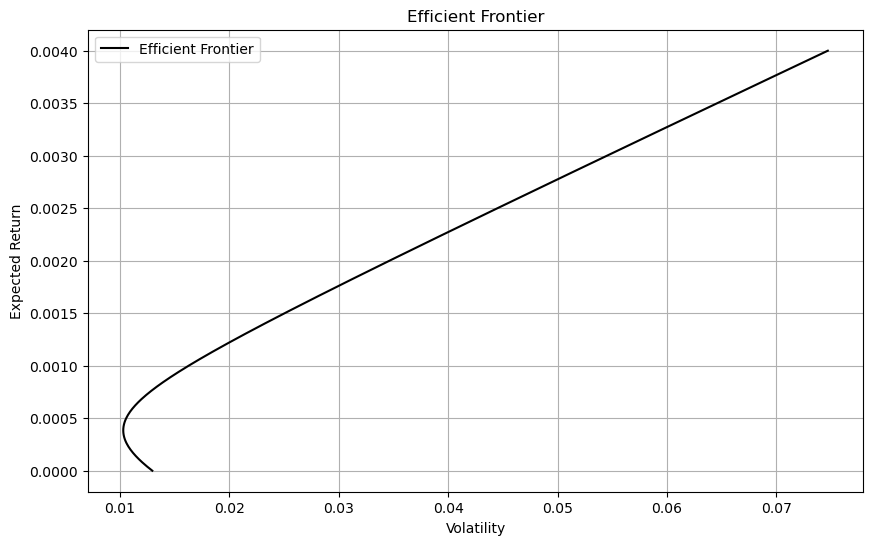

In [30]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [31]:
# The Most Efficient Portfolio is that which maximizes the Sharp Ratio
rfr = 0.0001

Let us find the Tangency Portfolio

Tangency Returns: $ \mu_T = \frac{2\pi_0 - \pi_1r_f}{\pi_1 - 2\pi_2r_f} $

In [32]:
# Obtain the values
pi_0 = coefficients[0]
pi_1 = coefficients[1]
pi_2 = coefficients[2]

tangency_returns = ((2*pi_0 - pi_1*rfr)/(pi_1 - 2*pi_2*rfr))
tangency_volat = eff_equation(coefficients, tangency_returns)

print(f"The Tangency Portfolio Returns are: {tangency_returns}")
print(f"The Tangency Portfolio Volatility is: {tangency_volat}")

The Tangency Portfolio Returns are: 0.0012753861068950528
The Tangency Portfolio Volatility is: 0.020940561221198504


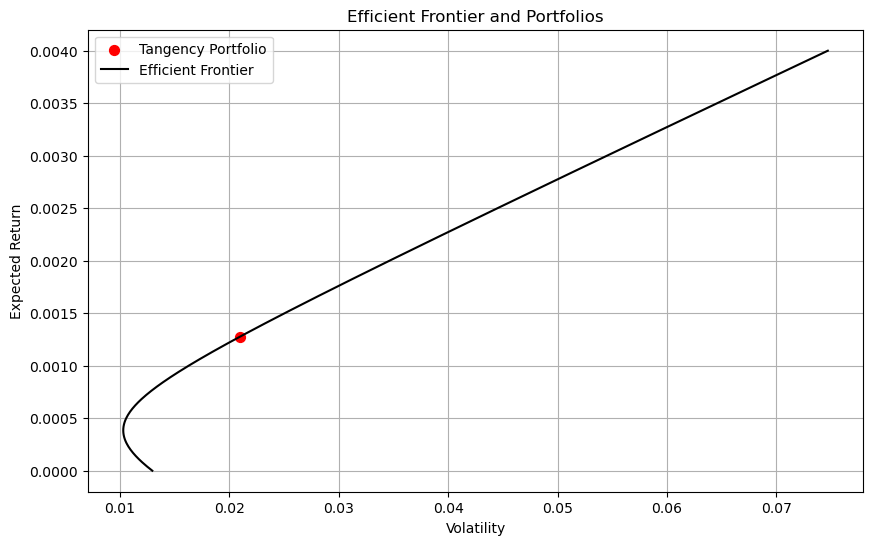

In [33]:
# Create the Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [34]:
# The Maximum Sharpe Ratio is the slope of the capital allocation line
sharpe_ratio = (tangency_returns - rfr)/tangency_volat

print(f"The Maximum Sharpe Ratio is: {sharpe_ratio}")

The Maximum Sharpe Ratio is: 0.05612963733298554


In [35]:
# Define the CAL
def CAL(
    rfr, 
    sigma_P
):
    return rfr + sharpe_ratio*sigma_P

In [36]:
# Create Range for Sigma
sigma_cal_values = np.linspace(0.0, 0.08, 400)

# Evaluate for each value of sigma
mu_cal_values = CAL(rfr, sigma_cal_values).reshape(-1, 1)

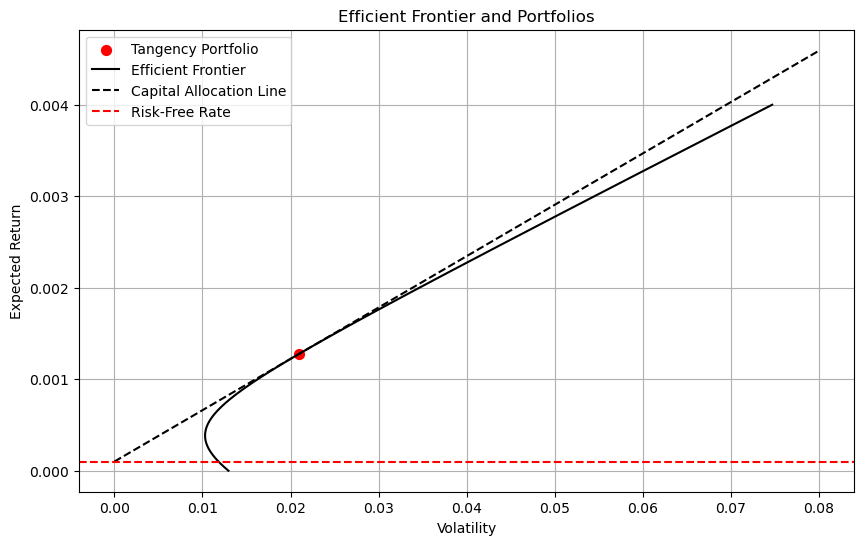

In [37]:
# Create Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.axhline(y=rfr, color='r', linestyle='--', label='Risk-Free Rate')

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [38]:
# Get the Weights of the Tangency Portfolio
def weights(desired_returns):
    # Number of assets
    n = len(expected_returns)
    
    # Create inputs
    mu = expected_returns.values.flatten().reshape(-1, 1)  # Expected Returns
    Sigma = cov_matrix.values  # Covariance Matrix
    Sigma_inv = np.linalg.inv(Sigma)  # Inverse Covariance Matrix
    iota = np.ones((n, 1))  # Vector of Ones

    # Create components
    A = np.dot(np.dot(mu.T, Sigma_inv), mu)
    B = np.dot(np.dot(iota.T, Sigma_inv), mu)
    C = np.dot(np.dot(iota.T, Sigma_inv), iota)
    D = (A * C) - (B * B)

    # Calculate the weights
    first_part = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu)
    second_part = ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

    return first_part + second_part 

In [39]:
# Calculate the weights
tangency_weights = weights(tangency_returns)

tangency_weights

array([[ 0.58682044],
       [ 0.51631208],
       [ 0.51766412],
       [-0.2553248 ],
       [-0.36547184]])

In [49]:
# Now let us assume we there are an investor willing to take lower risk to reach worse returns
cal_returns = 0.002

#In a normal case
normal_case_weights = weights(cal_returns)

print(normal_case_weights)
print(f'The sum of weights is: {normal_case_weights.sum().round(2)}')

[[ 1.0170583 ]
 [ 0.84577037]
 [ 0.9064161 ]
 [-0.98757112]
 [-0.78167364]]
The sum of weights is: 1.0


In [50]:
# Define the function to get the weights for the CAL
def capital_allocation_line_weights(
        desired_returns,
        tangency_returns = tangency_returns,
        risk_free_rate = rfr,
):
    # Calculate Tangents Weights
    tan_ws = weights(tangency_returns)
    
    # Calculate discount factor
    disfact = (desired_returns - risk_free_rate) / (tangency_returns - risk_free_rate)
    
    # Calculate weights
    cal_ws = tan_ws * disfact

    return cal_ws

In [51]:
# Calculate the weights
cal_ws = capital_allocation_line_weights(cal_returns)

print(cal_ws)
print(f'The sum of weights is: {cal_ws.sum().round(4)}')

if cal_ws.sum() < 1:
    print('You are a lender')
elif cal_ws.sum() > 1:
    print('You are a borrower')
else:
    print('You are special')

[[ 0.94858942]
 [ 0.83461336]
 [ 0.83679893]
 [-0.41273001]
 [-0.59078161]]
The sum of weights is: 1.6165
You are a borrower


In [52]:
# Get the volatility given the desired returns
def capital_allocation_line_volatility(desired_returns):
    # Calculate the volatility
    sigma = (desired_returns - rfr) / sharpe_ratio
    
    return sigma

In [53]:
# Calculate Volatility
cal_volat = capital_allocation_line_volatility(cal_returns)

print(f'The CAL Portfolio Risk: {cal_volat}')

The CAL Portfolio Risk: 0.033850209804997845


In [54]:
# You can get the same result by using the standard equation
cal_var = portfolio_variance(cal_ws, df_returns)
cal_volat_alt = np.sqrt(cal_var)

print(f'CAL Portfolio Variance: {cal_volat_alt[0][0]}')

CAL Portfolio Variance: 0.03385020980499784


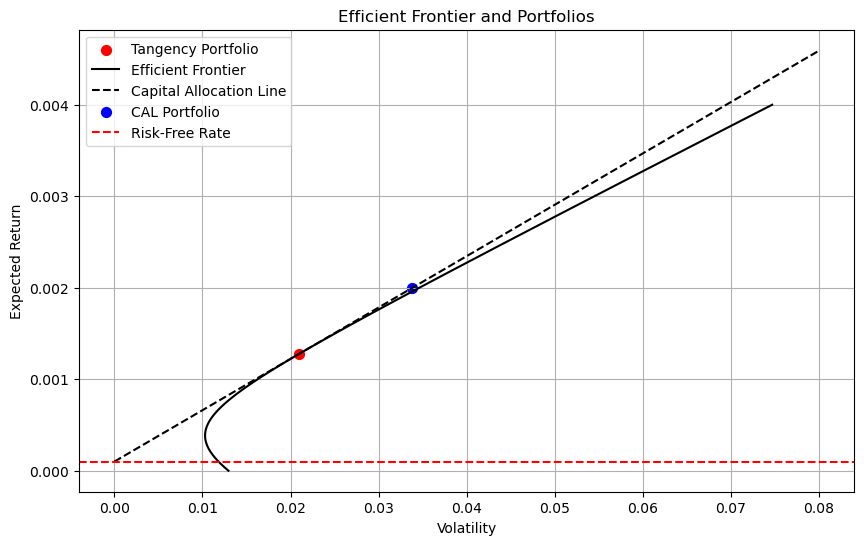

In [55]:
# Create Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.scatter(cal_volat, cal_returns, color='blue', s=50, label='CAL Portfolio')
plt.axhline(y=rfr, color='r', linestyle='--', label='Risk-Free Rate')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [56]:
# Create Portfolios
tangency_portfolio = df_returns @ tangency_weights

# Create DataFrame
df_returns_ports = df_returns.copy()

df_returns_ports['Tangency Portfolio'] = tangency_portfolio

df_returns_ports

,AAPL,AMZN,JPM,JNJ,XOM,Tangency Portfolio
2015-01-05 00:00:00,-0.028576,-0.020731,-0.031537,-0.007009,-0.027743,-0.031869
2015-01-06 00:00:00,0.000094,-0.023098,-0.026271,-0.004926,-0.005330,-0.022264
2015-01-07 00:00:00,0.013925,0.010544,0.001525,0.021836,0.010081,0.005145
2015-01-08 00:00:00,0.037702,0.006813,0.022100,0.007832,0.016508,0.029050
2015-01-09 00:00:00,0.001072,-0.011818,-0.017540,-0.013723,-0.001410,-0.010533
...,...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.016310,0.003985,0.000940,0.022853
2024-12-26 00:00:00,0.003171,-0.008770,0.003420,-0.001853,0.000845,-0.000733
2024-12-27 00:00:00,-0.013331,-0.014641,-0.008135,-0.003647,-0.000094,-0.018628
2024-12-30 00:00:00,-0.013352,-0.011010,-0.007700,-0.011859,-0.006785,-0.011999


### Comparing Different Portfolios ###

In [57]:
# Define the desired portfolios
returns_list = [0.001, 0.0015, 0.0025, 0.003]

# Loop over desired returns with index
for r, ret in enumerate(returns_list):
    
    # Calculate Weights
    ws = capital_allocation_line_weights(ret)
    
    # Calculate the Portfolio Returns
    portfolio = df_returns.values @ ws
    
    # Save it in the DataFrame
    df_returns_ports[f'port_{r}'] = portfolio
    

In [58]:
df_returns_ports

,AAPL,AMZN,JPM,JNJ,XOM,Tangency Portfolio,port_0,port_1,port_2,port_3
2015-01-05 00:00:00,-0.028576,-0.020731,-0.031537,-0.007009,-0.027743,-0.031869,-0.024402,-0.037959,-0.065073,-0.078630
2015-01-06 00:00:00,0.000094,-0.023098,-0.026271,-0.004926,-0.005330,-0.022264,-0.017048,-0.026519,-0.045461,-0.054932
2015-01-07 00:00:00,0.013925,0.010544,0.001525,0.021836,0.010081,0.005145,0.003940,0.006128,0.010505,0.012694
2015-01-08 00:00:00,0.037702,0.006813,0.022100,0.007832,0.016508,0.029050,0.022244,0.034601,0.059316,0.071674
2015-01-09 00:00:00,0.001072,-0.011818,-0.017540,-0.013723,-0.001410,-0.010533,-0.008066,-0.012546,-0.021508,-0.025989
...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.016310,0.003985,0.000940,0.022853,0.017498,0.027220,0.046662,0.056384
2024-12-26 00:00:00,0.003171,-0.008770,0.003420,-0.001853,0.000845,-0.000733,-0.000561,-0.000873,-0.001497,-0.001809
2024-12-27 00:00:00,-0.013331,-0.014641,-0.008135,-0.003647,-0.000094,-0.018628,-0.014263,-0.022188,-0.038036,-0.045960
2024-12-30 00:00:00,-0.013352,-0.011010,-0.007700,-0.011859,-0.006785,-0.011999,-0.009187,-0.014292,-0.024500,-0.029604


In [59]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [60]:
# Now the table
analytics_table = calculate_analytics(df_returns_ports)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,0.233536,0.284654,0.820421,-0.004855,-0.027362
AMZN,0.266007,0.326594,0.814489,-0.008223,-0.031091
JPM,0.161750,0.273194,0.592070,-0.005722,-0.025665
JNJ,0.060192,0.180753,0.333009,-0.003195,-0.016213
XOM,0.058425,0.277928,0.210215,-0.009469,-0.026262
Tangency Portfolio,0.321397,0.332421,0.966838,-0.009073,-0.033310
port_0,0.246096,0.254537,0.966838,-0.006952,-0.025506
port_1,0.382816,0.395946,0.966838,-0.010800,-0.039676
port_2,0.656255,0.678765,0.966838,-0.018464,-0.068015
port_3,0.792975,0.820174,0.966838,-0.022280,-0.082185
